### Обзор исходных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

plt.rcParams['figure.figsize'] = (10, 7)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head(5)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ClientProfile,TrasactionCategory
0,76871,36123,3957,887,4406,EUR,49,6,10,airtime,3,1000.0,1000,2018-11-15 02:18:49,2,0,4,3
1,73770,15642,4841,3829,4406,EUR,49,4,6,financial_services,2,-20.0,20,2018-11-15 02:19:08,2,0,0,2
2,26203,53941,4229,222,4683,EUR,49,6,1,airtime,3,500.0,500,2018-11-15 02:44:21,2,0,3,2
3,380,102363,648,2185,988,EUR,49,1,21,utility_bill,3,20000.0,21800,2018-11-15 03:32:55,2,0,3,1
4,28195,38780,4841,3829,988,EUR,49,4,6,financial_services,2,-644.0,644,2018-11-15 03:34:21,2,0,0,3


С datetime pandas работает гораздо быстрее, чем со строками, поэтому:

In [3]:
train['TransactionStartTime'] = pd.to_datetime(train['TransactionStartTime'])
test['TransactionStartTime'] = pd.to_datetime(test['TransactionStartTime'])

Удалю признаки, принимающие единственное значение

In [4]:
uni = [col for col in train.columns.drop('FraudResult') if (len(set(train[col])) == len(set(test[col])) == 1)]

train.drop(columns=uni, inplace = True)
test.drop(columns=uni, inplace = True)

Проверю данные на пропуски

In [5]:
train.isnull().values.any()

False

In [6]:
test.isnull().values.any()

False

Решение задачи начну с изучения данных. Т.к. мошеннические транзакции -- редкое событие, первую очередь обращу внимание на разбалансировку классов и вручную исследую, видны ли какие-то различия в распределении данных для "чистых" и мошеннических рядов.

In [7]:
train['FraudResult'].sum()/len(train)

0.0017524095631493302

В обучающей выборке оказалось около 2% мошеннических операций. Взглянем на них внимательнее, пока для удобства и наглядности убрав метаданные.

Итак, сравним распределения признаков для честных и мошеннических операций.

In [8]:
fraud = train[train['FraudResult'] == 1]
normal = train[train['FraudResult'] == 0]

#категориальные строковые признаки кодирую числом для корректного отображения
dict_product = {key: val for val, key in enumerate(set(normal['ProductCategory']))}
fraud = fraud.replace(dict_product)
normal = normal.replace(dict_product)
                
features = train.columns.drop(['TransactionId', 'SubscriptionId', 'BatchId', 'FraudResult', 
                                   'TransactionStartTime', 'AccountId', 'CustomerId'])

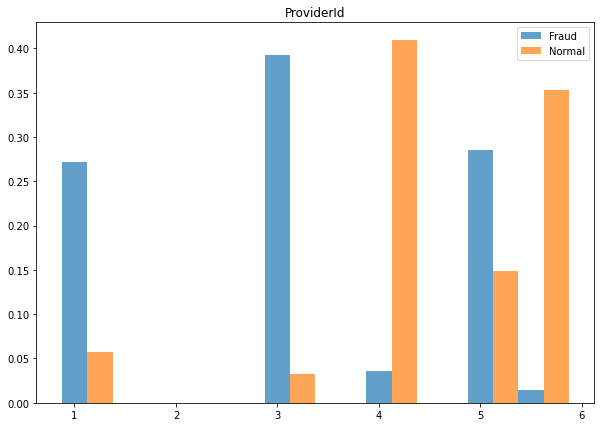

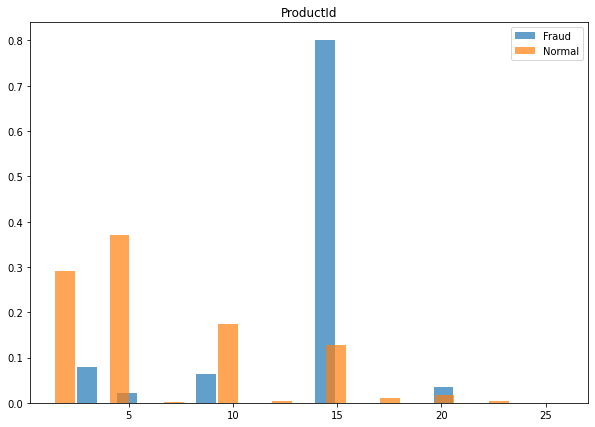

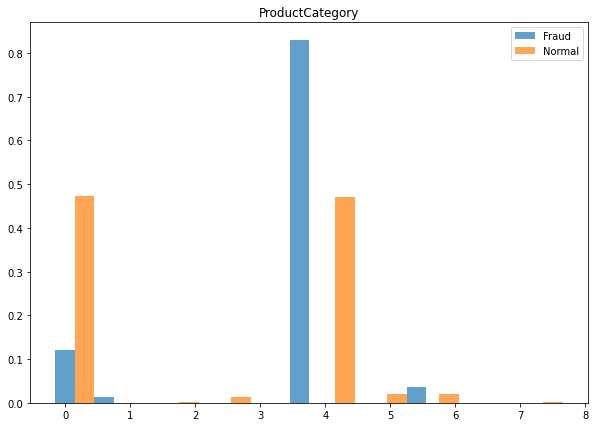

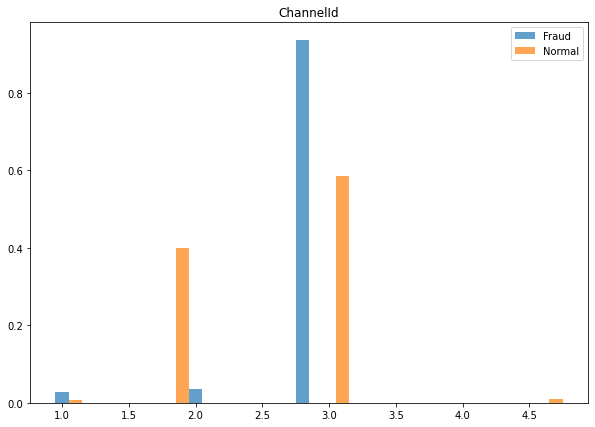

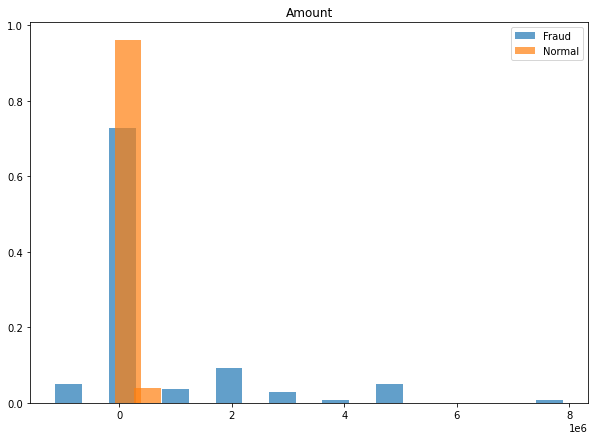

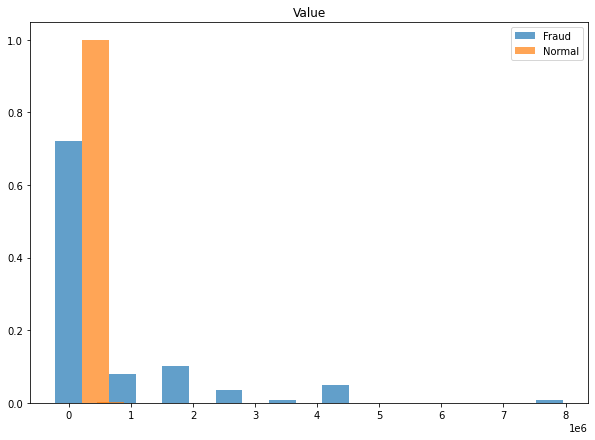

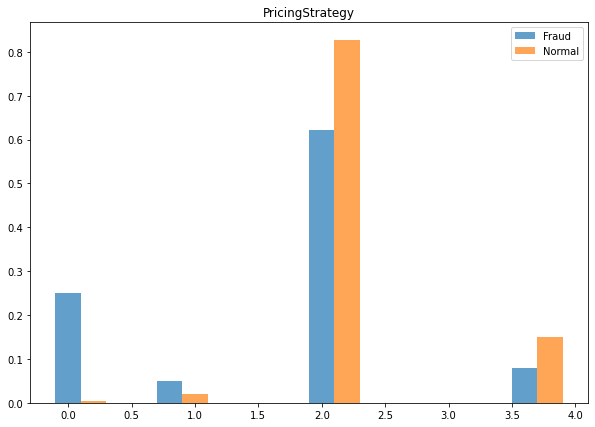

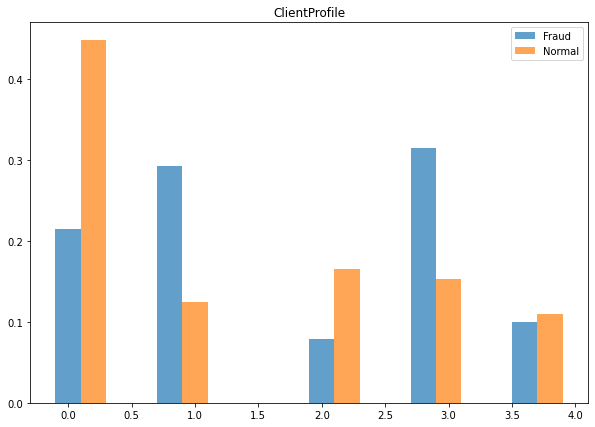

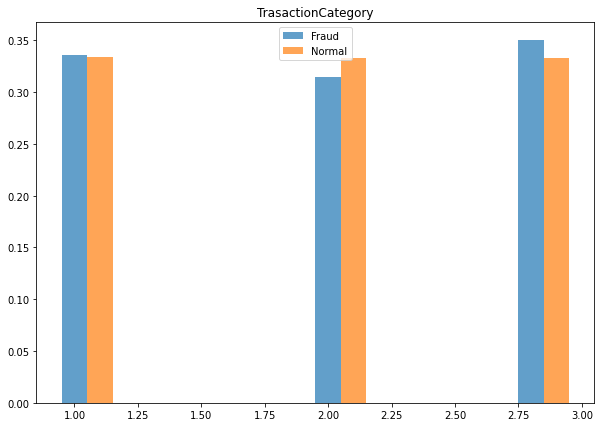

In [9]:
for feature in features:
    fig, ax = plt.subplots()

    fraud_h, fraud_bins = np.histogram(fraud[feature])
    norm_h, norm_bins = np.histogram(normal[feature])
    fraud_h, norm_h = fraud_h/len(fraud), norm_h/len(normal)

    width = (fraud_bins[1] - fraud_bins[0])/2

    ax.bar(fraud_bins[:-1], fraud_h, width=width, alpha = .7)
    ax.bar(norm_bins[:-1] + width, norm_h, width=width, alpha = .7)
    
    ax.legend(['Fraud', 'Normal'])
    
    plt.title(feature)
    plt.plot()

Из приведенных гистограмм уже можно сделать следующие выводы:
 
1. До 80% преступлений связаны с покупкой товара с номером 15. 

Из этого следует другое различие в распределении обычных пользователей и мошенников по поставщикам и категории товаров. Мошенники преимущественно работают с финансовыми сервисами (80%) и эфирным временем. Еще небольшой пик мошеннических транзакций виден в категориях транспорта и ТВ.

2. Почти все обманные операции проведены с 3-го канала 

Т.е. чаще всего мошенники пользуются ios. В реальной задаче это были бы не маловажные данные, т.к. 70% рынка мобильных телефонов в Германии (в данных встречается только 1 код страны, 49 - это код Германии) принадлежат Android согласно https://gs.statcounter.com/os-market-share/mobile/germany

3. Сделки с отрицательной стоимостью или слишком высокой почти наверняка мошеннические. 

Как следствие, сделки со слишком высоким Value наверняка мошеннические (признак избыточен).

4. Мошенники часто выбирают ценовую структуру 2, как и обычные пользователи, и 0, которая не пользуется спросом у честных покупателей.

5. Система определения рискованности транзакции остро нуждается в доработке :)

К сожалению, распределение количества покупок не дает информации о стратегиях мошенников (по этой причине не привожу график), частично из-за малого количества данных по ним. В целом понятно, что долго существующие аккаунты с большим числом покупок обычно надежны.


Также интересно посмотреть на метаданные.

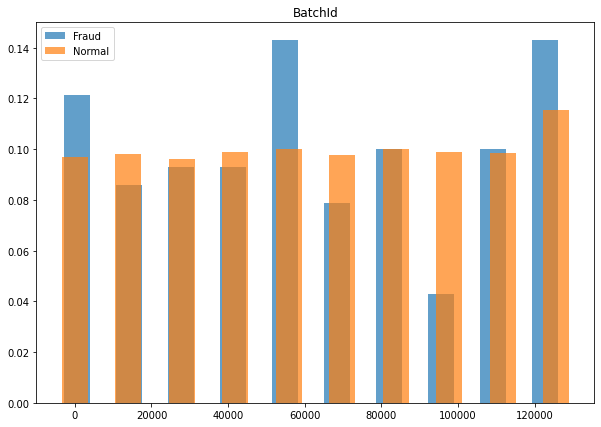

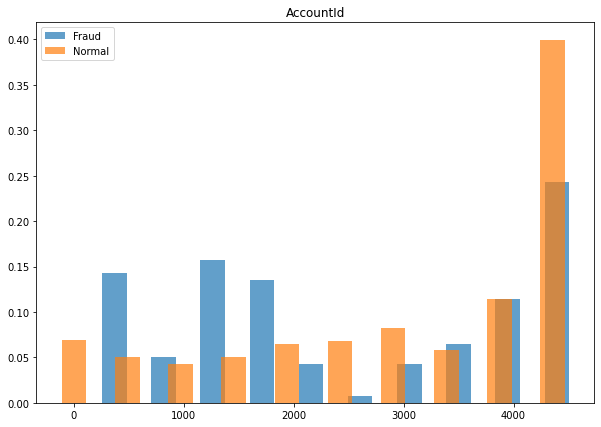

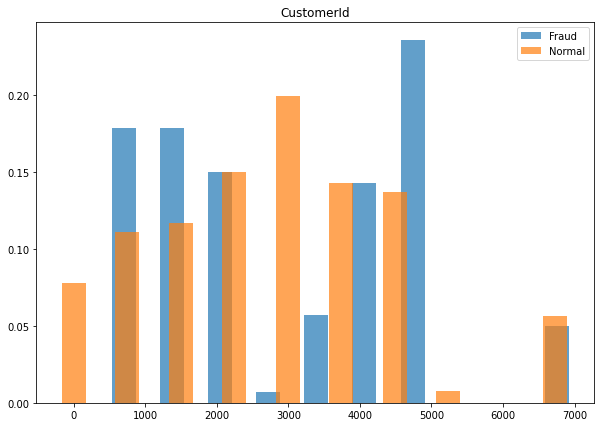

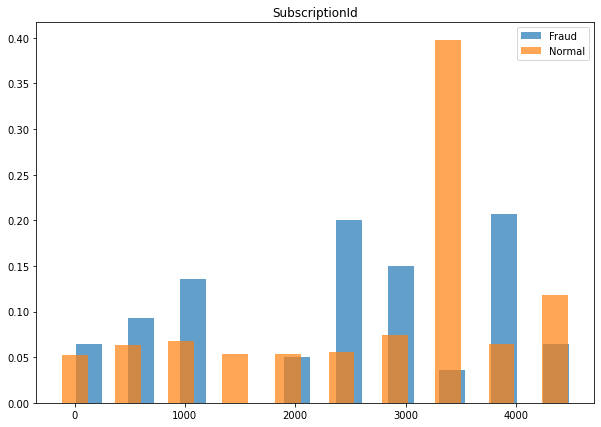

In [10]:
for feature in ['BatchId', 'AccountId', 'CustomerId', 'SubscriptionId']:
    fig, ax = plt.subplots()

    fraud_h, fraud_bins = np.histogram(fraud[feature])
    norm_h, norm_bins = np.histogram(normal[feature])
    fraud_h, norm_h = fraud_h/len(fraud), norm_h/len(normal)

    width = (fraud_bins[1] - fraud_bins[0])/2

    ax.bar(fraud_bins[:-1], fraud_h, width=width, alpha = .7)
    ax.bar(norm_bins[:-1], norm_h, width=width, alpha = .7)
    
    ax.legend(['Fraud', 'Normal'])
    
    plt.title(feature)
    plt.plot()

Понятно, что есть аккаунты, с которых никогда не проходит мошеннических транзакций, с которых они проходят и редко и с которых - часто. Эта информация полезна, если аккаунт\подписка\пользователь уже встречались в обучающей выборке.

Если мошенник активен в течение какого-то времени, то в батче транзакций, в который он попал, будет больше обманных операций. Такая информацияполезна, если моделью будет реккурентная нейронная сеть. В таком случае новые предсказания будут опираться не только на обучающую выборку, но и на уже сделанные ранее предсказания для тестовой, и транзакциям с аккаунтов, не попавших в обучающую выборку, или в каком-то батче, где до этого часто встречалось мошенничество, будет уделяться больше внимания.

Однако RNN - тяжелая артиллерия, к которой не хочется прибегать, если более легкие модели дадут хороший результат, поэтому я начну с более простых моделей и пока уберу этот признак.

In [11]:
class Preprocessor():
    '''Class for data preprocessing in sklearn API'''
    def __init__(self):
        self.regime = None
        self.dict = None
        
    def fit(self, X):
        self.dict = {key: val for val, key in enumerate(np.unique(X['ProductCategory']))}
        
    def transform(self, X, regime = 'train'):
        assert regime in ['train', 'test'], 'regime must be train or test'
        
        X_ = X.copy()
        X_ = X_.replace(self.dict)

        X_.drop(columns=['Value', 'TrasactionCategory', 'TransactionStartTime', #?
                         'BatchId', 'TransactionId'], inplace = True)
        if regime == 'train':
            X_.drop(columns=['FraudResult'], inplace = True)
            y_ = X['FraudResult']
            return X_, y_
        else:
            return X_
        
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Подбор модели: tree-based

После знакомства с данными более аккуратно обработаю их. 

Так как данные преимущественно категориальные, я выберу модель, основанную на деревьях. Дисбланас классов (к нему чувствительны деревья) попробую побороть, сместив распределение классов в обучающей выборке и убрав случайные честные транзакции. Зато выбор основанных на деревьях моделей позволяет сделать 2 упрощения:
1. Численные переменные, как правило, следует приводить в один диапазон. Это позволяет снизить смещенние внимания модели в сторону признаков с большими значениями, но для деревьев это не важно
2. Сейчас категориальные признаки закодированы целочисленно, из-за чего возникает ранжирование возможно равнозначной информации. Для деревьев это не становится проблемой. В других же случаях я предпочитаю one-hot encoding по этой причине, вдобавок с разреженными матрицами удобно работать, пока не встает вопрос ограничений по памяти. Здесь же отмечу, что вопрос со слишком высокой размерностью данных можно решить, например, РСА, ICA или LDA. В задаче я сознательно этого не делаю, потому что не считаю, что признаков слишком много, а неинформативные из них уже удалила вручную, ориентируясь на наглядные гистограммы. 

Техническая функция для отрисовки validation curve:

In [12]:
#plotting validation curve
from sklearn.model_selection import validation_curve

def plot_valid_curve(model, X, y, param_name, param_range):
    train_scores, valid_scores = validation_curve(model, X, y, 
                                                  param_name, param_range, cv=5,
                                                  scoring='f1')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    name = str(model.__class__).split('.')[-1][:-2]
    
    plt.title('Validation Curve for ' + name)
    plt.xlabel(param_name)
    plt.ylabel('f1-score')

    plt.plot(param_range, train_scores_mean, label="Training score",
                 color='b')
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color='b')
    plt.plot(param_range, valid_scores_mean, label="Cross-validation score",
                 color='r')
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color='r')
    plt.legend(loc='upper left')
    plt.show()

Итак, попробую бустинг над деревьями:

In [33]:
from sklearn.model_selection import train_test_split

prep = Preprocessor()
X_tr, y_tr = prep.fit_transform(train)

X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size = .33, random_state = 42)

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

xgb = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.2,
                max_depth = 7, n_estimators = 100, gamma = 1, subsample = 0.4)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(f1_score(y_train, xgb.predict(X_train)))

print(f1_score(y_test, xgb.predict(X_test)))

y_test[y_test != y_pred].values

[21:13:23] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
0.9239130434782609
0.9130434782608695


array([0, 1, 0, 1, 0, 1, 0, 1])

Отлично, попробую undersampling.

In [15]:
f1 = []
for i in range(10):
    inds = np.random.choice((y_train == 0).index, size=len(y_train) // 5)

    xgb.fit(X_train.drop(inds), y_train.drop(inds))

    y_pred = xgb.predict(X_test)

    f1.append(f1_score(y_test, y_pred))

    print(y_test[y_test != y_pred].values)
    
np.mean(f1)

[21:09:16] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[1 1 0 1 1 1 0 1 1 1 1 1]
[21:09:18] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0 1 0 1 1 0 1 1 0 1]
[21:09:19] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0 1 0 1 0 0 0 1 1 0]
[21:09:20] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0 0 0 1 0 0 0 1 0 1 0]
[21:09:22] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[1 1 0 1 1 1 0 0 1 0 1 1 1 0 1]
[21:09:23] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0 0 0 1 0 0 0 1 0 1 0 1]
[21:09:24] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0 0 1 0 1 1 1 

0.8615410753983245

На результат сильно влияет то, какие объекты случайно убираются из выборки.
Чтобы получить надежную оценку метрики на смещенном распределении данных, следовало бы усреднить на большем числе подвыборок, в бутстрепинге обычно мне встречалось 50 подвыборок, хотя это, конечно, rule of thumb.

Примерно можно сказать, что результат на undersampling чуть хуже, причем не видно смещения в ложноположительную ошибку (когда нормальные акции считаются подозрительными), и даже наоборот. Это плохо, так как ошибка по не-определению мошенничества должна быть для модели "дороже", чем по распознаванию обычной транзакции как мошенничества. 

### Anomaly detection

Также имеет смысл посмотреть в сторону алгоритмов поиска аномалий. Все же 1.8% объектов из выборки - это, конечно, выбросы, и может быть, unsupervised learning в этом случае окажется хорошим выбором.


kNN быстро учится, поэтому можно найти оптимальное число соседей через grid search.
Данные для него нужно нормировать, а категориальные признаки либо убрать, либо закодировать one-hot encoding. Это неприятно, так как есть информативные и уникальные данные, например, идентификатор пользователя. 
Решение подбором метрики расстояния (я выбрала косинусную меру) не сработало, поэтому я выбрала фичи путем максимизации результата, из категориальных оставив только те, у которых немного значений.

In [16]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import Normalizer

num_cols = ['ChannelId', 'Amount', 'ProductCategory']

norm = Normalizer().fit(X_train[num_cols]) 
X_train_norm = norm.transform(X_train[num_cols])

knn = KNN(3) 

knn.fit(X_train_norm, y_train)
y_pred = knn.predict(norm.transform(X_test[num_cols]))

f1_score(y_test, y_pred)

0.7816091954022988

In [17]:
y_test[y_pred != y_test].values

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1])

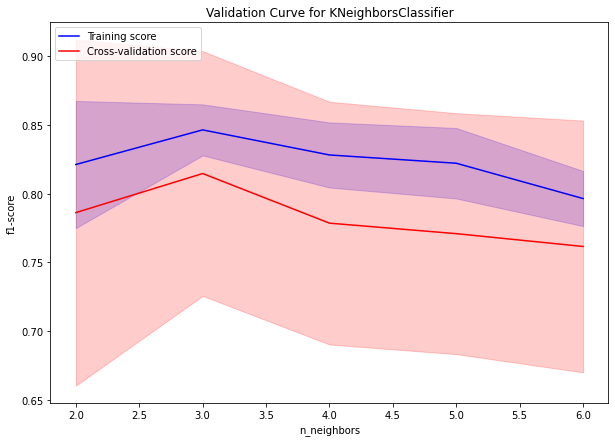

In [18]:
plot_valid_curve(knn, norm.transform(X_train[num_cols]), y_train, 'n_neighbors', range(2, 7))

Не плохо, но и не хорошо: knn переобучен (большая разница между качеством на валидационной и обучающей выборках) и вдобавок смещен к false negative ошибкам несмотря на undersampling. 

Еще были опробованы бэггинг над деревьями и one-class SVM. Их результаты неутешительны, поэтому не приведены здесь.

### Предсказание таргета

Итак, в качестве рабочей модели я выберу градиентный бустинг.

In [35]:
X_t = prep.transform(test, regime='test')

In [40]:
target = pd.DataFrame(data=np.array([test['TransactionId'], xgb.predict(X_t)]).T, 
                      columns=[['TransactionId', 'FraudResult']])

target.to_csv('target gordey.csv', index = 0)

In [41]:
target[['FraudResult']].sum()/len(target)

FraudResult    0.002726
dtype: float64

Распределение предсказаний немного отличается от распределения таргета на обучающих данных, впрочем, вопрос с ложноположительной ошибкой уже поднимался.

· **Какие дополнительные данные могли бы помочь в данной задаче?**

Возможно, более точное определение локации, чем код страны, могло бы помочь выявить взлом пользователя. Авторизация из неожиданного места требует подтверждения. Аналогично мог бы пригодится уникальный идентификатор устройства, с которой осуществлена покупка.


· **Какой методы для решения задачи вы бы хотели использовать, но не успели?**

Я бы, возможно, посмотрела в сторону байесовских сетей и оптимизированных RNN: LSTM/GRU. Для RNN при этом нужно обработать данные: численные стандартизировать (например, StandartScaler'ом из библиотеки sklearn), а категориальные признаки можно было закодировать эмбеддингами прямо в нейросети, то есть нейросетке подавать на вход два тензора: с категориальными данными и с вещественными. Мотивация использования RNN была рассмотрена в разделе первичного обзора данных. В целом я думаю, что бустинг хорошо показал себя в этой задаче и в отношении результат\ресурсы это оптимальный выбор.

· **Какая бизнес-метрика будет, на ваш взгляд, основной в данной задаче?**


Я бы предложила считать выгоду от отлова мошеннических транзакций следующим образом:

$$f = \frac{S_{TP} - S_{FN} - \alpha \cdot S_{FP}}{S_{TP} + S_{TN} - S_{FN} - S_{FP}},$$

где $S_{TP}$ -- сумма средств по отловленным мошенническим транзакциям; где $S_{TN}$ -- сумма средств по обычным прошедшим транзакциям; $S_{FN}$ -- сумма по неотловленным мошенническим; $S_{FP}$ -- сумма по ошибочно замороженным нормальным транзакциям; $\alpha \leq$ 1 - понижающий коэффициент.

### Дополнительные нюансы решения

Далее я дам комментарии о шагах решения, не вошедших в отчет.

#### Подбор модели
Помимо приведенных результатов, из алгоритмов я пробовала решающие деревья, их ансамблирование в Random Forest, а также SVM, их работа оказалась неудовлетворительной.


#### Feature engineering
Хочется вынести на обсуждение на мой взгляд хорошие, хоть и не "выстрелившие" идеи:

1. Вычислить для каждого пользователя стандартные статистики (среднее и дисперсию) и для каждой его транзакции добавить признаки отклонения от этих значений. Это позволит получить представление о типичном поведении пользователя и отлавливать необычные для него транзакции.

Однако на деле с новыми признаками результат не улучшился ни в модели градиентного бустинга, ни в решающем дереве, ни в kNN. При этом я пробовала добавлять как их абсолютное значение, так и процентное.

Возможно, лучшего результата можно было бы добиться подбором оптимального периода усреднения. Например, смотреть характерные среднее и дисперсию не за всю историю пользователя, а за неделю, месяц и т.д.

2. Обратить внимание на временной интервал между транзакциями (слишком частые покупки - подозрительно).

Посмотрим на то, как распределены во времени действия нескольких пользователей, уличенных в мошенничестве.

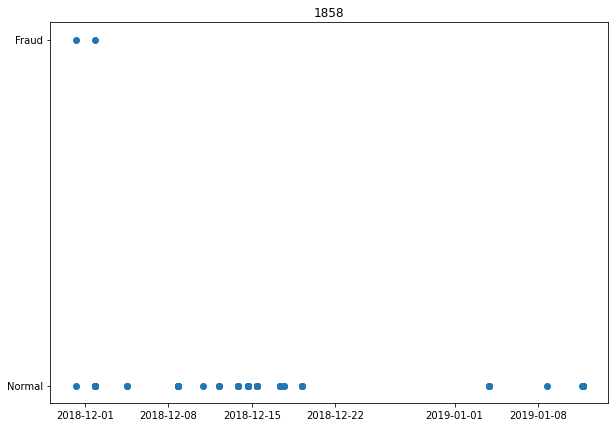

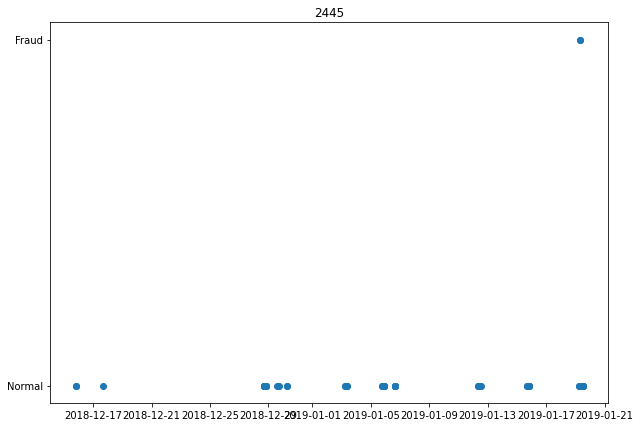

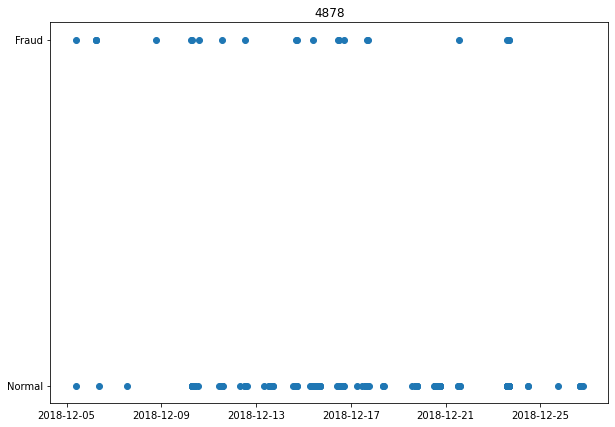

In [22]:
frauds_more_than_one = [item for item, count in \
                        np.array(np.unique(fraud['CustomerId'], return_counts = True)).T if count > 1]

for cust in frauds_more_than_one[5::5]:
    plt.title(cust)
    plt.scatter(train['TransactionStartTime'][train['CustomerId'] == cust], 
                train['FraudResult'][train['CustomerId'] == cust])
    plt.yticks([0, 1], ['Normal', 'Fraud'])
    plt.show()

В этой случайной подвыборке нет ни одного чистого мошенника, не совершавшего честных сделок.

Не видно единой стратегии. Кто-то совершает много и честных, и обманных сделок, а кто-то, по-видимому, просто ошибается. При этом мошенники, придерживающиеся первой схемы, совершают частые покупки. Как часто это делают честные активные покупатели, смотреть напрямую было бы слишком долго. Поэтому у меня возникла идея ввести новые признаки: среднее время между транзакциями пользователя (в Юлианском формате) и время с последней покупки.

Итак, вычисление статистик поведения пользователей (при этом доступ к тестовым данным не является data leakage, т.к. на момент предсказания модели будут доступны эти характеристики, правда, её придется дообучать с каждым новым поступлением информации):

In [23]:
EPS = 1e-5

means_stds = pd.concat([train[['TransactionId', 'CustomerId', 'Amount']], 
                        test[['TransactionId', 'CustomerId', 'Amount']]])

means_stds['Mean amount'] = means_stds.groupby('CustomerId')['Amount'].transform('mean')
means_stds['Mean std'] = means_stds.groupby('CustomerId')['Amount'].transform('std')
means_stds['d Amount'] = (means_stds['Mean amount'] - means_stds['Amount'])
means_stds['d std'] = means_stds['d Amount']/(means_stds['Mean std'] + EPS)

means_stds.fillna(0, inplace = True)

Вычисление пауз между транзакциями и склейка в один датасет:

In [24]:
train_exp = train.copy()


train_exp['TransactionStartTime'] = pd.DatetimeIndex(train_exp['TransactionStartTime']).to_julian_date()
train_exp['TransactionPause'] = train_exp.groupby('CustomerId')['TransactionStartTime'].diff().fillna(0)
train_exp['MeanTransactionPause'] = train_exp.groupby('CustomerId')['TransactionPause'].transform('mean')

train_exp = pd.merge(train_exp, means_stds[['TransactionId', 'd Amount', 'd std']],
                     on = 'TransactionId')

X_exp, y_exp = prep.fit_transform(train_exp)
X_train, X_test, y_train, y_test = train_test_split(X_exp, y_exp, test_size = .33, random_state = 42)

In [25]:
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(f1_score(y_train, xgb.predict(X_train)))

print(f1_score(y_test, xgb.predict(X_test)))

y_test[y_test != y_pred].values

[21:11:03] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
0.907103825136612
0.8695652173913043


array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

Для бустинга ничего не изменилось, немного понизилось качество.
Метод ближайших соседей упал:

In [26]:
num_cols = ['ChannelId', 'd Amount', 'd std', 'ProductCategory', 'TransactionPause']

norm = Normalizer().fit(X_train[num_cols]) 
X_train_norm = norm.transform(X_train[num_cols])

knn = KNN(3) 

knn.fit(X_train_norm, y_train)
y_pred = knn.predict(norm.transform(X_test[num_cols]))

f1_score(y_test, y_pred)

0.5

Впрочем, он и до этого был неустойчив относительно входного надора данных.
Как видно, feature engineering здесь не помог добиться желаемого эффекта.